In [1]:
# set up logging
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,)

logger = logging.getLogger(__name__)

In [2]:
# export
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from typing import *
import re
import ast

pd.set_option('display.max_colwidth', None)

In [3]:
annot_path = "../../Datasets/oxford-iiit-pet/annotations/xmls"
img_dir = "../../Datasets/oxford-iiit-pet/images/"
lbl_pth = '../labels.names'

In [4]:
# export
def xml_to_df(annot_path:str)->pd.DataFrame:
    """
    Convert xml files to a pandas dataframe
    Args:
     annot_path: directory where the annotations are stored.
     img_dir   : directory where the images are stored.
    """
    xml_list = []
    for xml_file in glob.glob(annot_path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [5]:
def read_dict(fname:str):
    """
    Reads in a dictionary from a file
    """
    f = open(fname, "r")
    label_dict = f.read()
    label_dict = ast.literal_eval(label_dict)
    f.close()
    return label_dict

In [6]:
def rev_dict(d:Dict)->Dict:
    """
    Reverse a dictionary mapping
    """
    inv_dict = {v: k for k, v in d.items()} 
    return inv_dict

In [7]:
def parse_data(img_dir:str, annot_dir:str, dict_path:str)->pd.DataFrame:
    """
    Loads in the annotations from the xml files
    and generates a DataFrame. Where each entry corresponds
    to the path where images are stored and each image 
    has a bounding box denoted by xmin, ymin, xmax, ymax
    Integer targets are stored under targets.
    
    Args:
     img_dit   (str): Directory where the images are stored.
     annot_dir (str): Directory where the xml files are strored.
     dict_path (str): Path to the labels dictionary.
    
    """
    logger.info(f"Image Directory: {img_dir}")
    logger.info(f"Annotation Directory: {annot_dir}")
    logger.info(f"Path to labels: {dict_path}")
    
    # Convert the xml to dataframe
    df = xml_to_df(annot_dir)
    df['filename'] = [os.path.join(img_dir,f) for f in df['filename'].values]
    
    # Regular expression to grab the Class_name from the File_names
    pat = r'/([^/]+)_\d+.jpg$'
    pat = re.compile(pat)
    # Extract the Class_names
    df["classes"] = [pat.search(fname).group(1).lower() for fname in df.filename]
    
    # Read in the label dictionary
    label_dict = rev_dict(read_dict(fname=dict_path))
    # convert class labels to integers
    df['targets'] = [label_dict[idx] for idx in df['classes'].values]
    logger.info(f"Number of unique classes found: {len(df['targets'].unique())}")
    
    return df

In [8]:
df = parse_data(img_dir, annot_path, lbl_pth)

09/18/2020 10:15:08 INFO Image Directory: ../../Datasets/oxford-iiit-pet/images/
09/18/2020 10:15:08 INFO Annotation Directory: ../../Datasets/oxford-iiit-pet/annotations/xmls
09/18/2020 10:15:08 INFO Path to labels: ../labels.names
09/18/2020 10:15:09 INFO Number of unique classes found: 37


In [9]:
df.head()

,filename,width,height,xmin,ymin,xmax,ymax,classes,targets
0,../../Datasets/oxford-iiit-pet/images/British_Shorthair_10.jpg,233,350,83,29,197,142,british_shorthair,9
1,../../Datasets/oxford-iiit-pet/images/german_shorthaired_119.jpg,500,500,128,22,240,222,german_shorthaired,14
2,../../Datasets/oxford-iiit-pet/images/english_setter_158.jpg,333,500,97,35,304,199,english_setter,13
3,../../Datasets/oxford-iiit-pet/images/Siamese_178.jpg,500,400,32,18,363,369,siamese,32
4,../../Datasets/oxford-iiit-pet/images/pomeranian_162.jpg,222,300,19,32,123,129,pomeranian,24


In [10]:
import sys
sys.path.append('/Users/ayushman/Desktop/retinanet_pet_detector')

In [11]:
from display_preds import Visualizer

In [12]:
labels = read_dict(fname=lbl_pth)

In [13]:
vis = Visualizer(class_names=labels)

09/18/2020 10:15:13 INFO Visualizer Initialized


In [14]:
img = df.filename[0]

rec = df.loc[df.filename == img]

target = list(rec['targets'].values)
bbox = rec[["xmin", "ymin", "xmax", "ymax"]].values

09/18/2020 10:15:15 INFO Found 1 bounding boxes on the given image


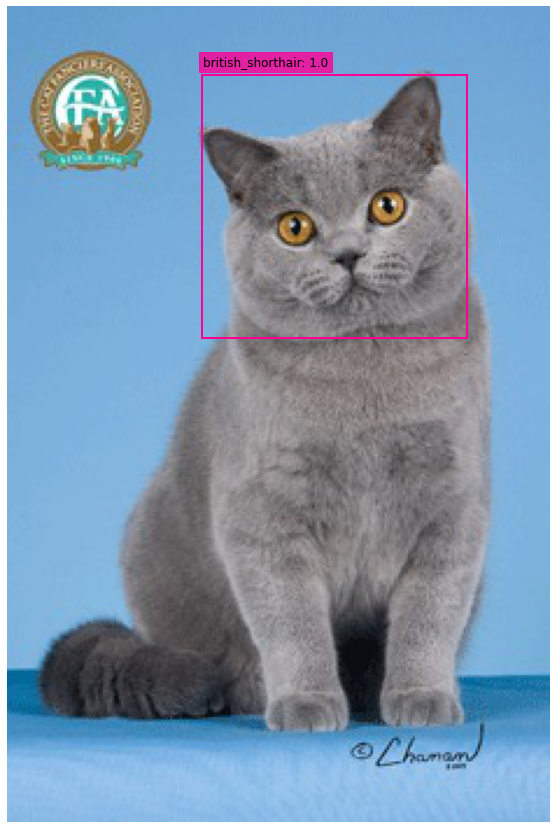

In [15]:
vis.draw_bboxes(img=img, boxes=bbox, classes=target)